# Homework 7 - Graphs and Dimension Reduction

In this homework, you'll get a bit of practice with graphs and dimension reduction.  You'll see how some of the work you did earlier, such as dense matrix-matrix multiplication and the Egyptian algorithm, can apply to these problems.

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sklearn
import scipy.linalg as la
from sklearn.neighbors import BallTree
import pickle
import pandas as pd
from numba import njit

## Problem 0 - Nearest Neighbors Graphs (25 points)

Let's consider the problem of creating a nearest neighbor graph from a point cloud

First, let's consider the problem of generating a dataset with some structure - a noisy sphere

In [20]:
def sample_noisy_sphere(n, **kw):
    """
    Sample n points uniformly at random from the k-sphere
    embedded in d dimensions.
    
    Add normal nosie with variance sigma
    
    Arguments:
        n - number of samples
    
    Optional arguments:
        r - radius of circle (default 1.0)
        k - dimension of sphere (default k = 1 == circle)
        sigma - noise variance (default 0.1)
        d - dimension of embedded space (default k+1)
    """
    r = kw.get('r', 1.0)
    k = kw.get('k', 1)
    sigma = kw.get('sigma', 0.1)
    d = kw.get('d', k+1)

    X = np.random.randn(n,k+1)
    X = r * X / np.linalg.norm(X, axis=1).reshape(n,-1) # project onto sphere
    
    Q, R = np.linalg.qr(np.random.randn(d, k+1))
    X = X @ Q.T # apply random rotation

    return X + sigma*np.random.randn(n,d)

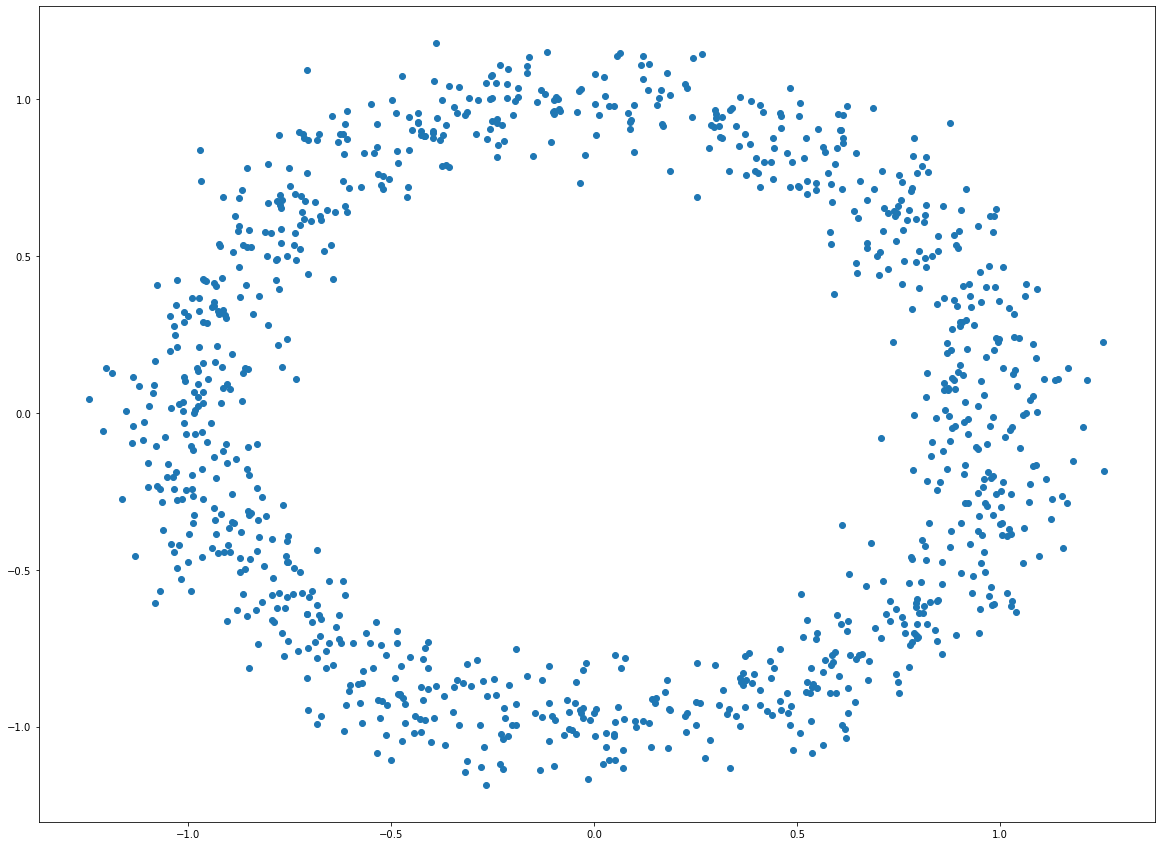

In [241]:
X = sample_noisy_sphere(1000, d=2)
plt.scatter(X[:,0], X[:,1])
plt.show()

We'll define a neighbors graph $G$ of our data set `X` as a graph with a vertex set $0,\dots,n-1$.  The graph contains an edge $(i,j)$ if `X[i]` and `X[j]` are neighbors.

### Part A - k-Nearest Neighbors Graph (15 points)


Write a function `knn_graph(X, k=5, **kwargs)` which returns a `k`-nearest neighbors graph of the data set of `X`, returned as a networkX `Graph`.  We'll say `X[i]` and `X[j]` are neighbors if `i` is one of the `k`-nearest neighbors of `j` **or** `j` is one of the `k`-nearest neighbors of `i`. You should use [`sklearn.neighbors.BallTree`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html) for neighbor queries, and the unspecified keyword arguments should be used to construct the `BallTree` (that way you can change the metric).  Set an edge attribute `dist` for each edge which contains the distance between the points it connects.

Don't add self-edges to the graph.  That is, don't count the point `i` as one of the `k` nearest neighbors of `i`.

In [249]:
## Your code here
def knn_graph(X, k=5, **kw):
    """
    return k-nearest neighbors networkx graph GG
    """
    me = kw.get('metric', 'euclidean')
    p = kw.get('p', None)
    n = X.shape[0]
    
    if p != None:
        tree = BallTree(X, metric=me, p=p) # construct balltree
    else:
        tree = BallTree(X, metric=me) # construct balltree
    s = pickle.dumps(tree)                     
    tree_copy = pickle.loads(s)
        
    G = nx.Graph()
    for i in range(n):
        G.add_node(tuple(X[i])) # create graph with X as nodes
            
    for i in range(n):
        dis, ind = tree_copy.query(X[i:i+1], k+1)  # find k-nearest neighbors and dist using balltree
        for j in range(k):
            G.add_edge(tuple(X[i]), tuple(X[ind[0][j+1]]), dist=(dis[0][j+1]))
    return G

Visualize the `knn_graph` (use default parameters) of the noisy circle data set `X` generated above using networkX `draw`.  You can experiment with different layouts to find a nice visualization.

Graph with 1000 nodes and 3129 edges


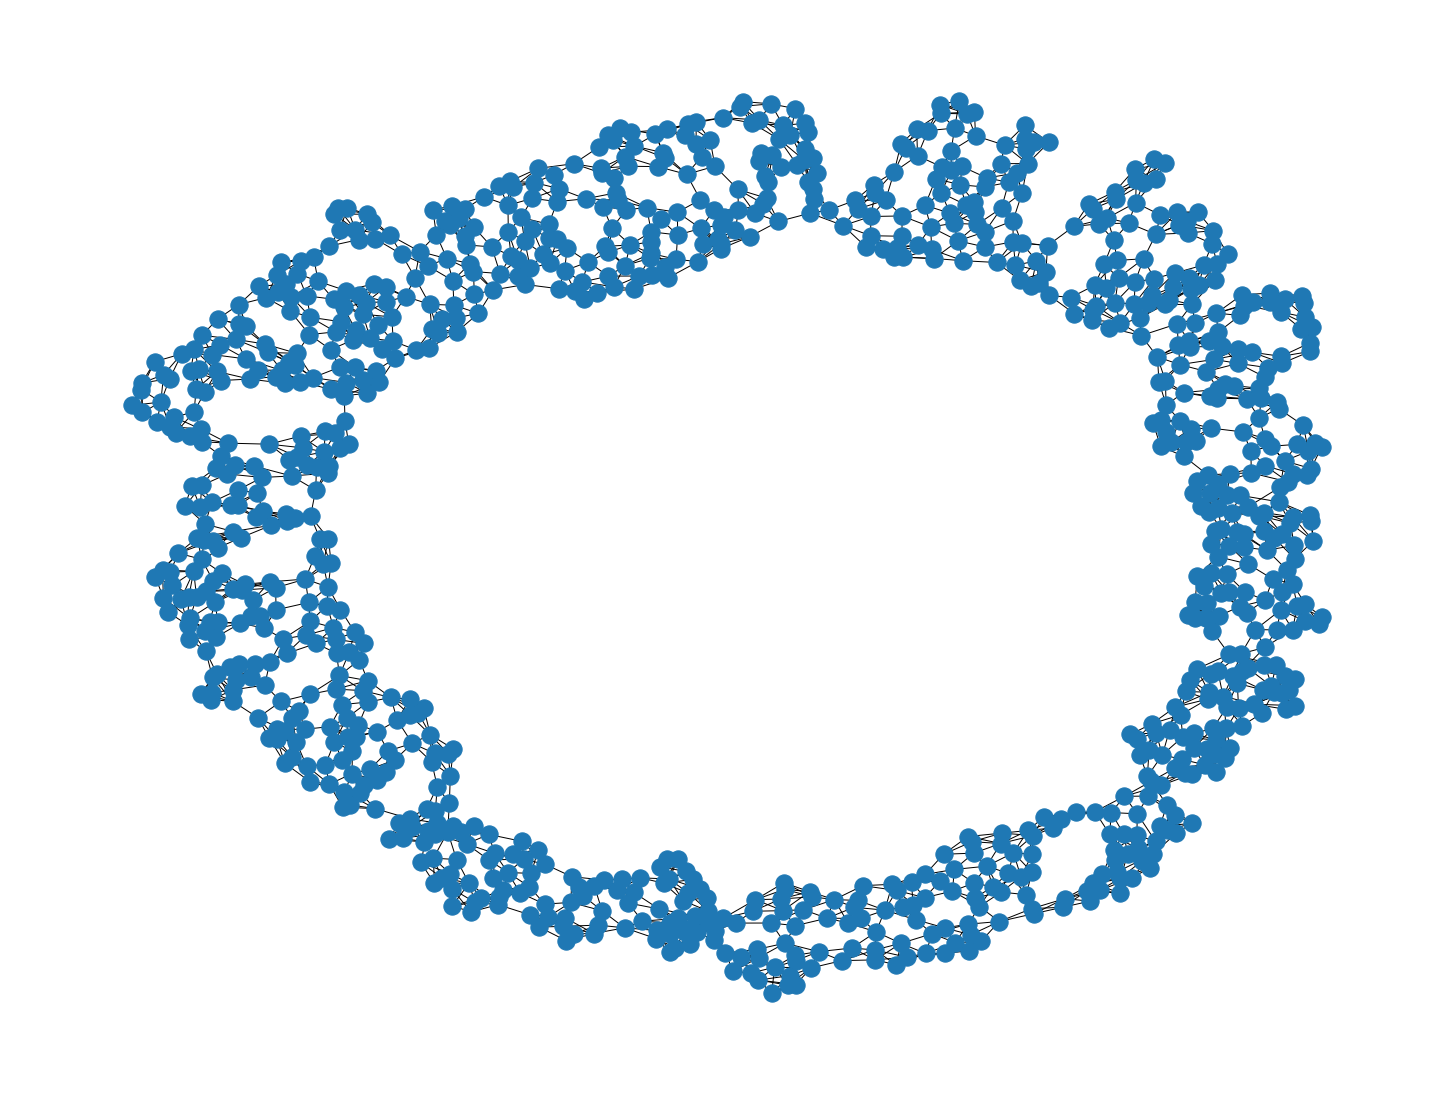

In [250]:
## Your code here
G = knn_graph(X, k=5)
print(G)
plt.rcParams["figure.figsize"] = (20,15)
nx.draw_kamada_kawai(G)
plt.show()

### Part B - r-Nearest Neighbors Graph (10 points)

Write a function `rnn_graph(X, r=0.2, **kwargs)` which returns a `r`-nearest neighbors graph of `X` returned as a networkX `Graph`.  In this case `X[i]` and `X[j]` are neighbors if the distance between the two points is less than or equal to `r`.  Again, use a `BallTree` for queries, pass `**kwargs` to the `BallTree` constructor, and set the edge attribute `dist` for each edge in the graph.

In [214]:
## Your code here
def rnn_graph(X, r=0.2, **kw):
    """
    return r-nearest neighbors nextworkx graph of X
    """
    me = kw.get('metric', 'euclidean')
    n = X.shape[0]
    
    tree = BallTree(X, metric=me) # create balltree
    G = nx.Graph()
    for i in range(n):
        G.add_node(tuple(X[i]))
        
    for i in range(n):
        ind, dis = tree.query_radius(X[i:i+1], r=r, return_distance=True)
        ind = ind[0].tolist() # simplify the ind array and the dis array
        dis = dis[0].tolist()
        ind.remove(i)
        dis.remove(0)
        k = len(ind)
        for j in range(k):
            G.add_edge(tuple(X[i]), tuple(X[ind[j]]), dist=dis[j])
    return G

Visualize the `rnn_graph` (use default parameters) of the noisy circle data set `X` generated above using networkX `draw`.  You can experiment with different layouts to find a nice visualization.

Graph with 1000 nodes and 22498 edges


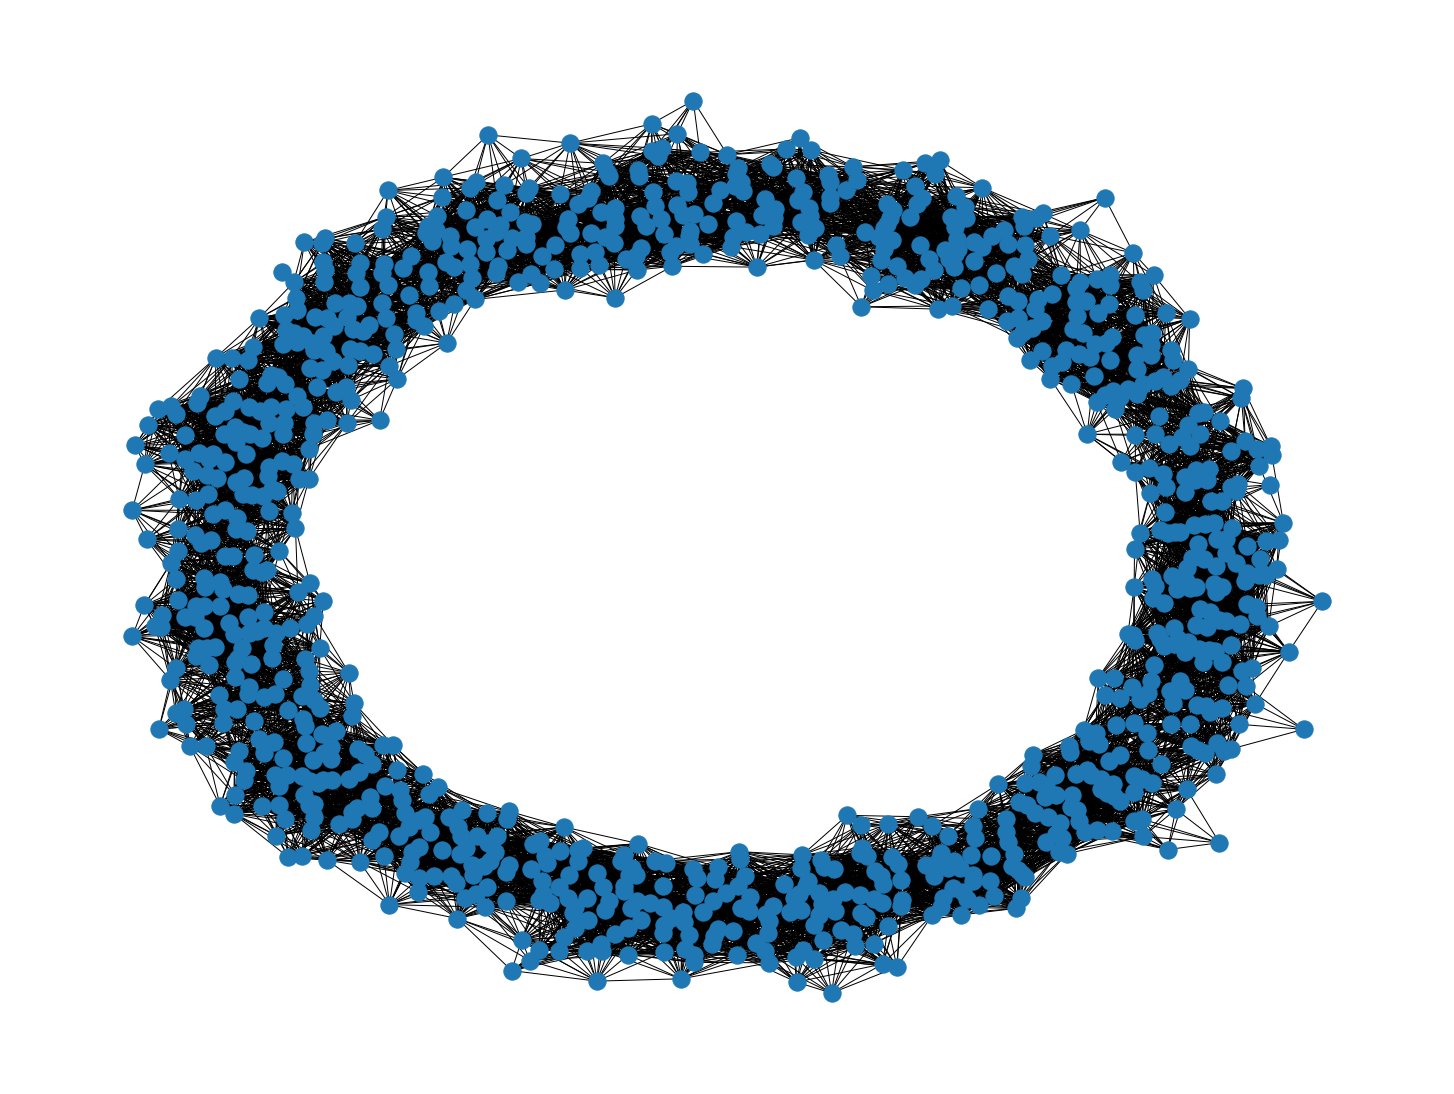

In [242]:
## Your code here
G1 = rnn_graph(X)
print(G1)
nx.draw_kamada_kawai(G1)
plt.show()

## Problem 1 - Shortest Paths and Matrix Multiplication (35 points)

We're interested in computing the shortest-path metric between nodes in a graph.  Recall that a path between nodes $i$ and $j$ is a sequence of edges that begins at $i$ and ends at $j$.

We'll define the distance from a node $i$ to itself as 0.

If $i$ and $j$ are connected by an edge $(i,j)$ then $d(i,j) = 1$.  Alternatively, we can weight the edge so $d(i,j) = w_{i,j}$.

One way to compute paths of length 2 is to create a dense matrix $A$ which is the same as the adjacency matrix except
\begin{equation}
A_{i,j} = \begin{cases}
0 & i = j\\
w_{i,j} & (i,j) \in E\\
\infty & \text{otherwise}
\end{cases}
\end{equation}

We then compute 
\begin{equation}
A^2_{i,j} = \min_k \{ A_{i,k} + A_{k,j} \}
\end{equation}

The entry $A^2_{i,j}$ is then finite if there exists a path with at most 2 edges between $i$ and $j$, and if it is finite, the entry is the (weighted) length of the path.  The expression above looks at all nodes $k$ and sees if $i$ connects to $k$ and $j$ connects to $k$, and if so forms a path from $i$ to $j$ through $k$.  If there are multiple paths through different $k$, we take the shortest (weighted) path. 

This turns out to be an "exotic" form of matrix-matrix multiplication over the [$(\min,+)$ tropical semiring](https://en.wikipedia.org/wiki/Tropical_semiring), so $A^2 = A \times A$ in this sense.  Matrix-matrix multiplication is defined for any semiring, which a mathematical term for a set of numbers related by notions of addition and multiplication.  In the case of the $(\min, +)$ semiring, standard addition is replaced by the $\min$ operator, and standard multiplication is replaced by addition.

We can compute shortes paths on at most $k$ edges by computing the matrix power $A^k$ over this semiring.
### Part A - Tropical Matrix-Matrix Multiplication (15 points)

Write a function `matmul_minplus(A, B)` which performs matrix-matrix multiplication in this manner.  Here is pseudocode for the function

```
function matmul_minplus(A, B):
    m, p = A.shape
    p, n = B.shape
    initialze empty m x n matrix C
    for i in range(m), j in range(n), k in range(p):
        C[i,j] = min_k { A[i,k] + B[k,j] }
        
    return C
```

Assuming `A` and `B`, and `C` are in row-major order, loop over `i`, `j`, and `k` in the best memory access order.  Use `numba` to make your function comile just-in-time.  Hint: `numba` seems to like Python's built in `min` rather than `np.min`

In [41]:
## Your code here
@ njit
def matmul_minplus(A, B):
    """
    Tropical matrix multiplication with ikj order
    """
    m, p = A.shape[0], A.shape[1]
    n = B.shape[1]
    C = np.ones((m, n))*np.inf  # entries are infinity
    for i in range(m):
        for k in range(p):
            for j in range(n):
                C[i,j] = min(C[i,j], A[i,k]+B[k,j])
    return C

### Part B - Create the Adjacency Matrix (5 points)

Write a funciton `adj_dist(G)` which returns the variation of the adjacency matrix described above for a networkX graph `G` (with $\infty$ where there are no edges).  The output should be a dense numpy array.  Use the `dist` edge attribute to weight each edge (i.e. if there is an edge $(i,j)$, you should have $A_{i,j} = d(x_i,x_j)$).  Hint: look at the `weight` keyword argument of `nx.adj_matrix`.

In [42]:
## Your code here
def adj_dist(G):
    """
    return modified adjacency matrix
    """
    A = nx.adjacency_matrix(G, weight="dist")
    A[A==0]=np.inf
    
    return A.todense()

### Part C - Shortest Path Metric (10 points)
Now, we can compute a matrix with all pairs shortest paths.  Write a function `shortest_path_metric(G)` which computes a $n \times n$ matrix which is the shortest path distance matrix $A^\infty$ using repeated matrix-matrix multiplication over the $(\min, +)$-semiring.  $A^\infty$ would encode all shortest paths of any length.  Note that any spanning tree has at most `n-1` edges so $A^\infty = A^N = A^{n-1}$ for any $N \ge n-1$.

For this problem, use a version of the Egyptian algorithm for powers.  In this case, it is probably easiest to compute $A^N$ where $N$ is the smallest power of 2 larger than $n-1$ (i.e. $N = 2^{\lceil\log_2(n - 1)\rceil}$, where $\lceil \cdot \rceil$ is the ceiling function which rounds up to the nearest integer).

In [182]:
## Your code here
import math

def power(A, n):
    """
    computes the power a ** n

    assume n is a nonegative even integer
    """
    if A.shape[0]==A.shape[1]:  # check whether input is square matrix
        if n == 1:
            return A
        if n == 0:
            return np.zeros(a.ndim)
        else:
            return power(matmul_minplus(A, A), n // 2)

def shortest_path_metric(G):
    """
    return the shortest path matrix
    """
    # precompile 
    At = np.arange(16).reshape(4,4)
    temp = matmul_minplus(At, At)
    
    A = adj_dist(G)
    n = A.shape[0]
    N = 2**(math.ceil(np.log2(n-1)))
    
    return power(A, N)

### Part D -  Time Complexity (5 points)

What is the asymptotic time complexity (use $\Theta$) of this algorithm for computing the shortest path metric on $G$ in terms of $n$, the number of nodes, and $m$, the number of edges?  Note that in practice, there are a variety of algorithms to compute shortest paths which are faster - see the [NetworkX documentation](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html) for some implementations.

---

*your answer here*

## Problem 2 - Multidimensional Scaling (20 points)

[Mulitdimensional scaling (MDS)](https://en.wikipedia.org/wiki/Multidimensional_scaling) seeks to find an embedding of $n$ data points in euclidean space that best respects pairwise distances according to the following objective

\begin{equation}
\mathop{\textsf{minimize}}_{X} \|B - XX^T\|_F
\end{equation}
Where $X$ is the embedding coordinates (an $n\times k$ matrix), $B$ will be defined below, and $\|\cdot \|_F$ is the Frobenius matrix norm $\|A\|_F = \sqrt{\sum_{i,j} A_{i,j}^2}$.

$B$ and $XX^T$ are symmetric, so the optimal result is given by the optimal rank-$k$ approximation to $B$, which can be computed using an eigenvalue decomposition
\begin{equation}
B = V \Lambda V^T
\end{equation}
And setting $X = V_k \Lambda^{1/2}_k$ where $V_k$ spans the largest $k$-dimensional eigenspace and $\Lambda_k$ is the diagonal matrix with the associated eigenvalues.

Let's now discuss the matrix $B$.  [Recall](https://caam37830.github.io/book/08_geometry/distances.html#pairwise-distances) how we might compute the matrix of pairwise Euclidean distances from a data $X$.  For simplicity, let's consdier the square of distances, so $D_{i,j} = \|x_i - x_j\|_2^2$
\begin{equation}
D = 1 x^{2T} + x^2 1^T - 2 X X^T
\end{equation}

The question we're interested in is how we might recover $X$ from the matrix $D$ (i.e. how to get an embedding from the pairwise distances).  First note that if we had some sort of ground truth, we can never hope to recover it, because Euclidean space is shift and rotation invariant, meaning that $d(x, y) = d(Qx + v, Qy + v)$ for any orthogonal matrix $Q$ and vector $v$.  Without loss of generality, we can "center" the matrix $X$ so that columns sum to 0, using $X' = (I - \frac{1}{n}11^T) X$.  We'll call the projection matrix $J = (I - \frac{1}{n}11^T)$ the "centering matrix".  We can confirm $J 1 = 1 - \frac{1}{n}11^T 1 = 1 - 1 = 0$, meaning that the nullspace of $J$ consists of constant vectors.

All this is to say that if $X' = J X$, then $d(x'_i - x'_j) = d(x_i, x_j)$ in Euclidean space.

We see that if we can get rid of the rank-1 terms $1 x^{2T} + x^2 1^T$ in the matrix $D$ that it will be easy to recover $XX^T$ using an eigenvalue decomposition.  To do this, we form the matrix
\begin{equation}
B = -\frac{1}{2}J D J^T
\end{equation}
If we apply this to the matrix $D$ formed from squared Euclidean distances above, we see
\begin{equation}
B = (JX)(JX)^T
\end{equation}
We can recover $JX$ (up to rotations) using an eigenvalue decomposition.

Now we have an algorithm to recover a Euclidean embedding from the matrix of pairwise distances.  An observation is that there is nothing stopping us from finding a Euclidean embedding when $D$ does not come from Euclidean distances, but from some other metric.  In this case, the recovered $X$ will give coordinates which "optimally" respect the original metric, even when the original metric can't be embedded in Euclidean space.

We now have an algorithm for data visualization given pairwise distance information, the classical MDS algorithm:
1. Form the matrix $D$ so $D_{i,j} = d(x_i, x_j)^2$ (even when the distance $d$ isn't Euclidean)
2. Form the matrix $B = -\frac{1}{2} J D J^T$
3. Compute the eigenvalue decomposition $B = V\Lambda V^T$
4. Return a $k$-dimensional embedding $X = V_k \Lambda_k^{1/2}$ (recall that for `eigh` $V_k$ is the last `k` columns of the eigenvector matrix)

Finally, note there are a variety of variations to MDS.  The one we're implementing is probably the simplest.

### Part A - Center a Matrix (5 points)

Write a function `center_matrix(D)` which given a matrix $D$ returns the matrix $-\frac{1}{2} J D J^T$

In [200]:
## Your code here
def center_matrix(D):
    """
    return B=-0.5*J*D*J^t
    """
    n = D.shape[0]
    one = np.ones(n)
    J = np.identity(n)-1/n*np.outer(one, one)
    return -0.5*J@D@J.T

### Part B - Implement the MDS algorithm (5 points)

Write a function `MDS(D, k=2)` which returns the `k`-dimensional Euclidean embedding for a matrix of pairwise distances `D`.

In [160]:
## Your code here
def MDS(D, k=2):
    """
    return the k-dim euclidean embedding for D
    """
    B = center_matrix(D)
    w, v = la.eigh(B)
    Vk = v[:,-k:]
    wk = w[-k:]
    Wk = np.diag(wk)
    
    return Vk@Wk**0.5

### Part C - Use your implementation (10 points)

Use the noisy circle data generated in problem 0 for your input data `X`.  Use your `MDS` function to get coordinates for the data after computing pairwise distances with the following metrics.  Visualize each embedding using a scatter plot.

1. Euclidean Metric
2. $L^1$ metric (`cityblock` in scipy)
3. $L^\infty$ metric (`chebyshev` in scipy)
4. Cosine distance (`cosine` in scipy)
5. Shortest path metric for the 5-nearest neighbors graph on `X` computed with euclidean distance (you can use Problems 0 and 1)
6. Shortest path metric for the $r$-nearest neighbors graph on `X`, with `r=0.1` and euclidean distance (you can use Problems 0 and 1).

In [238]:
## Your code here
def pairwise(X, **kw):
    """
    return pairwise distance matrix
    """
    me = kw.get('metric', euclidean)
    m = X.shape[0]
    D = np.zeros((m,m))
    
    for i in range(m):
        for j in range(m):
            D[i,j] = (me(X[i], X[j]))**2
            
    return D

In [166]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import cosine

D2 = pairwise(X)  # euclidean
E2 = MDS(D2)

D1 = pairwise(X, metric=cityblock) # L^1
E1 = MDS(D1)

Dinf = pairwise(X, metric=chebyshev) # L^{infinity}
Einf = MDS(Dinf)

Dcos = pairwise(X, metric=cosine) # cosine distance
Ecos = MDS(Dcos)

In [247]:
H1 = shortest_path_metric(G) # 5-nearest neighbor metrics
X1 = MDS(H1)

/var/folders/0l/16z1x7f921x1hdj3spvhldym0000gn/T/ipykernel_37191/2535775591.py:23: SparseEfficiencyWarning:

Comparing a sparse matrix with 0 using == is inefficient, try using != instead.

/Users/lijinnan/.conda/envs/pycourse/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [243]:
H2 = shortest_path_metric(G1) # 0.2-nearest neighbor metrics
X2 = MDS(H2)

/var/folders/0l/16z1x7f921x1hdj3spvhldym0000gn/T/ipykernel_37191/2535775591.py:23: SparseEfficiencyWarning:

Comparing a sparse matrix with 0 using == is inefficient, try using != instead.

/Users/lijinnan/.conda/envs/pycourse/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



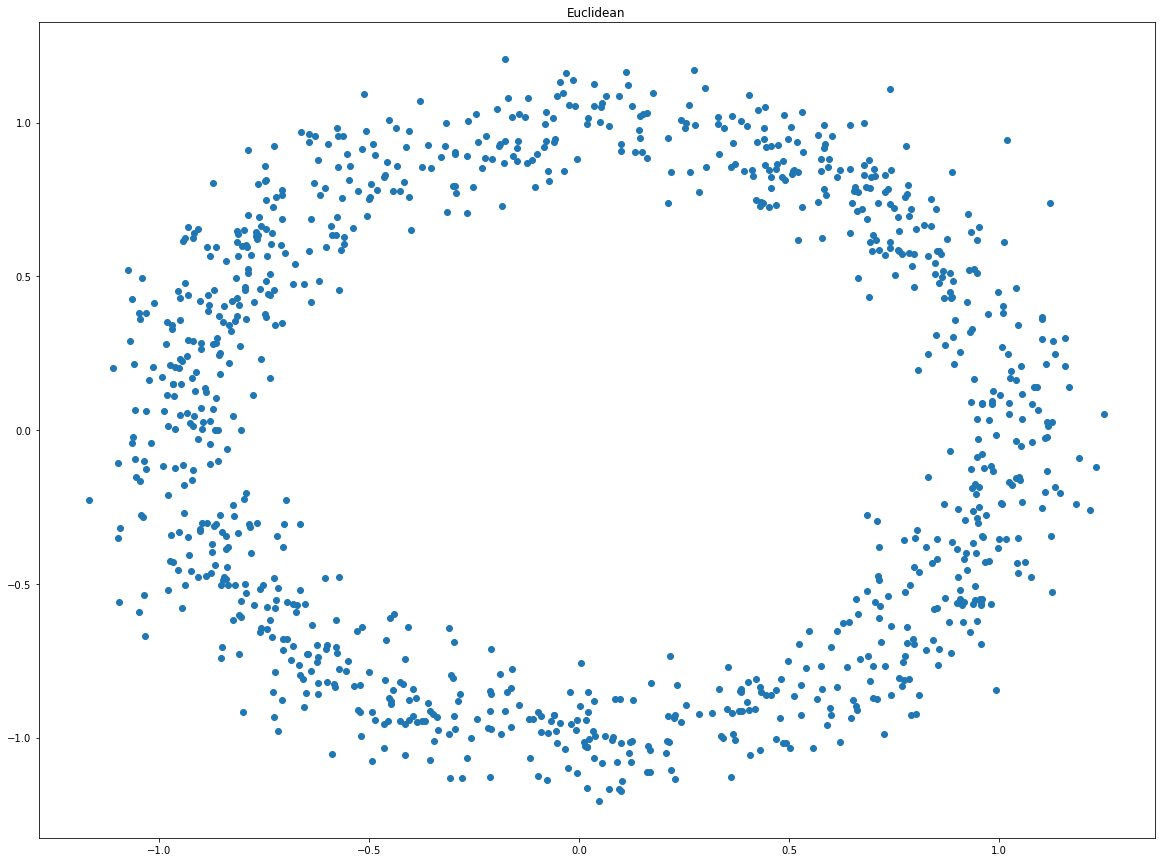

In [167]:
plt.scatter(E2[:,0], E2[:,1])
plt.title('Euclidean')
plt.show()

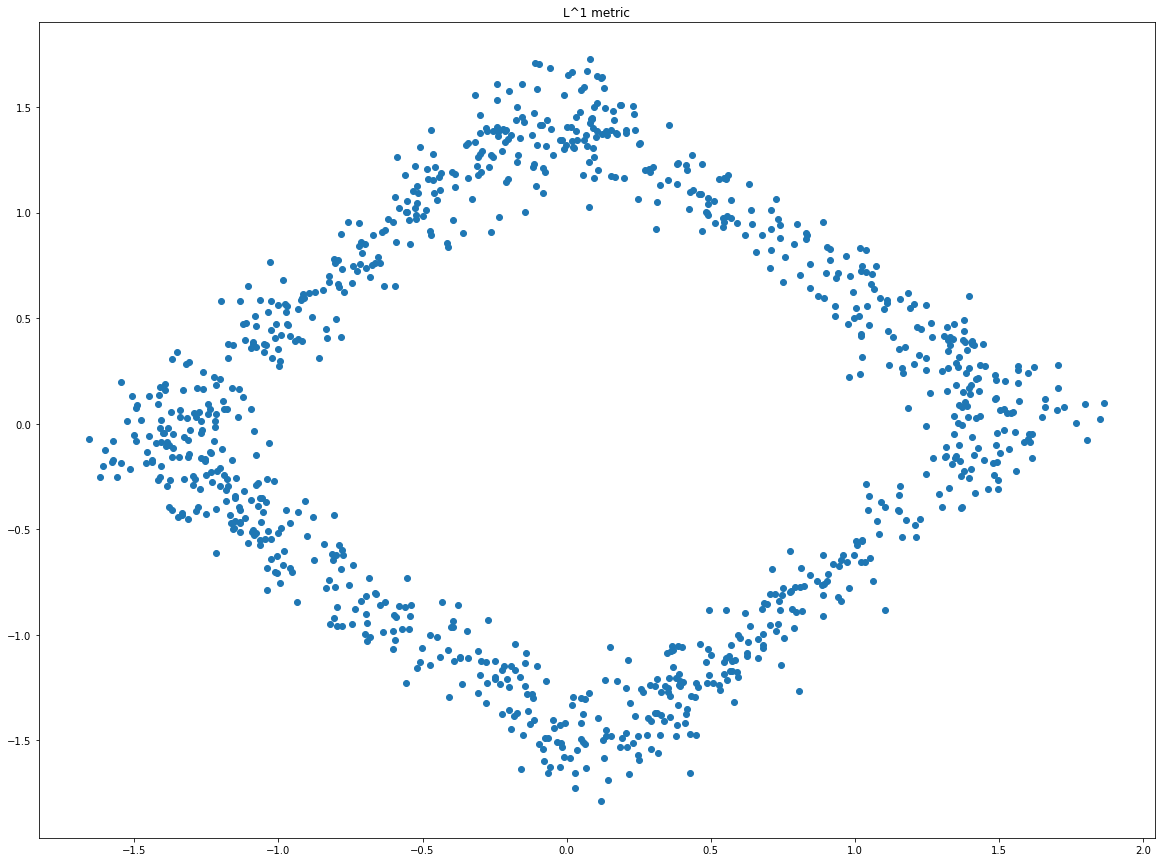

In [168]:
plt.scatter(E1[:,0], E1[:,1])
plt.title('L^1 metric')
plt.show()

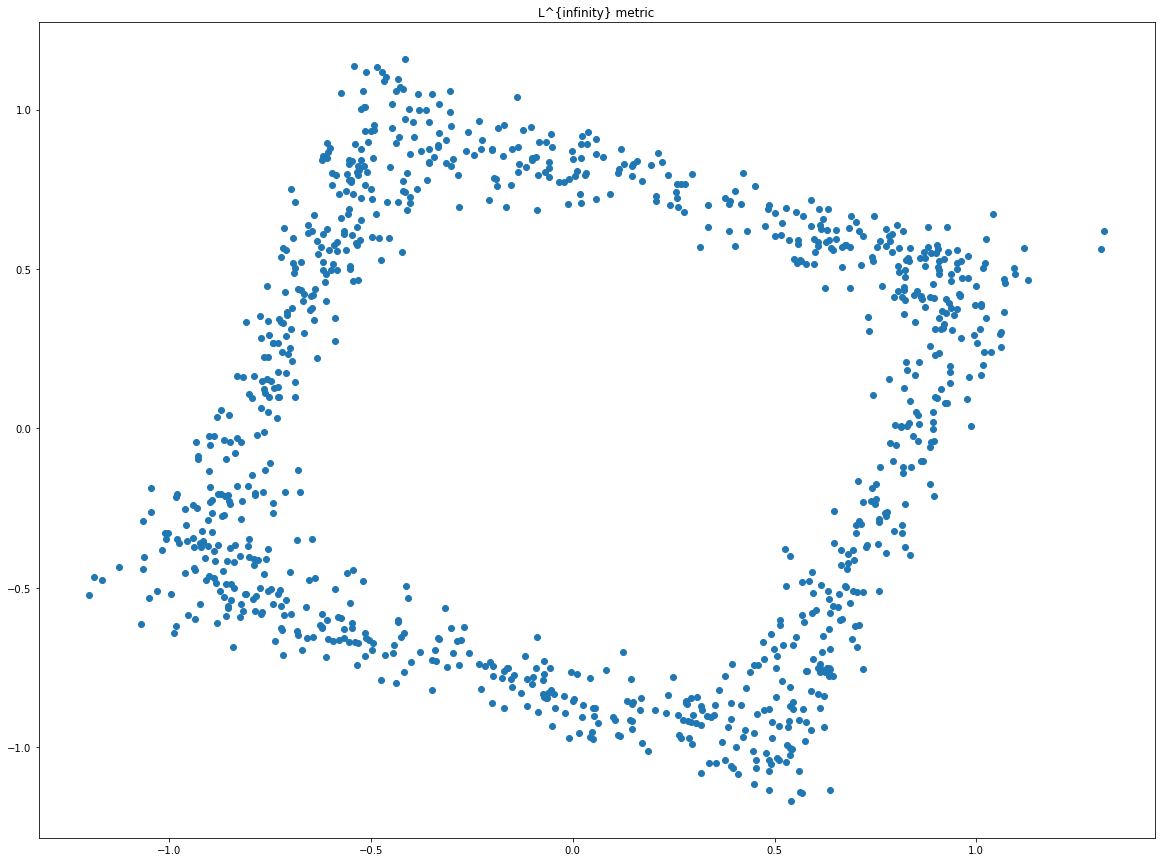

In [169]:
plt.scatter(Einf[:,0], Einf[:,1])
plt.title('L^{infinity} metric')
plt.show()

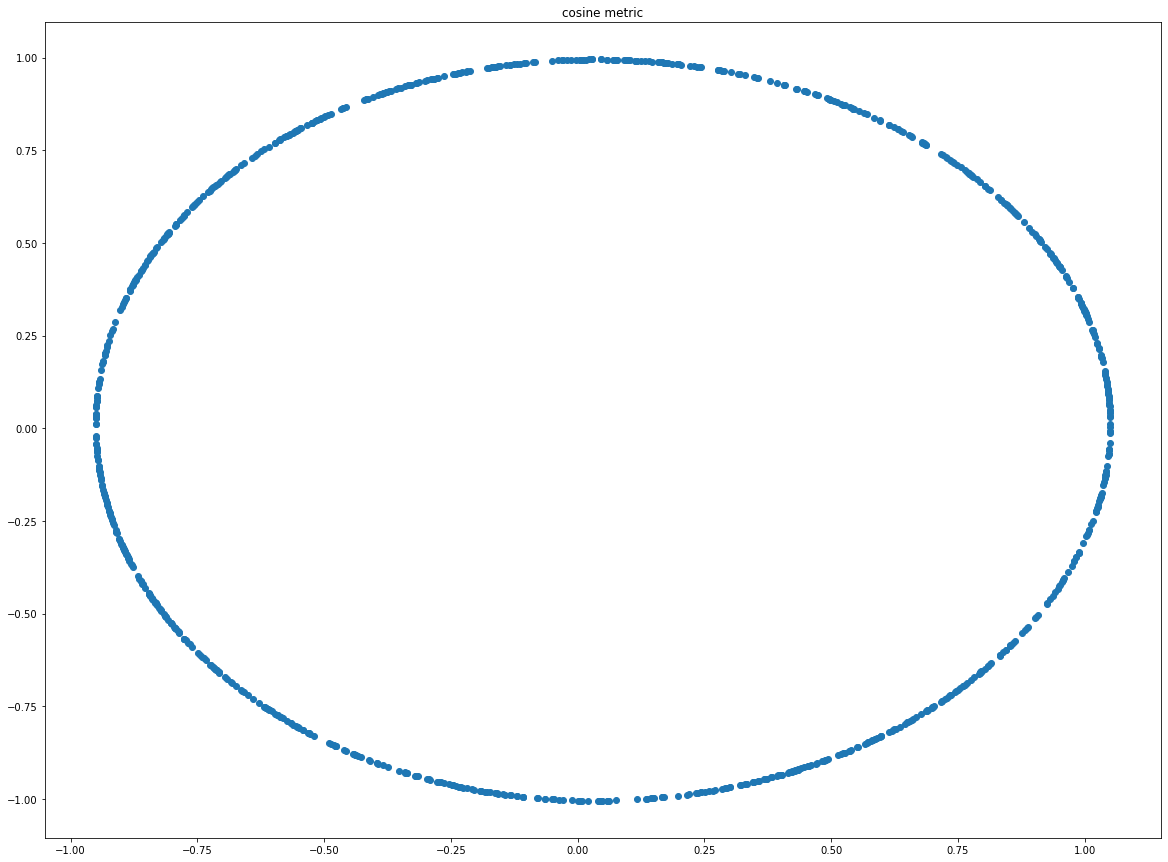

In [170]:
plt.scatter(Ecos[:,0], Ecos[:,1])
plt.title('cosine metric')
plt.show()

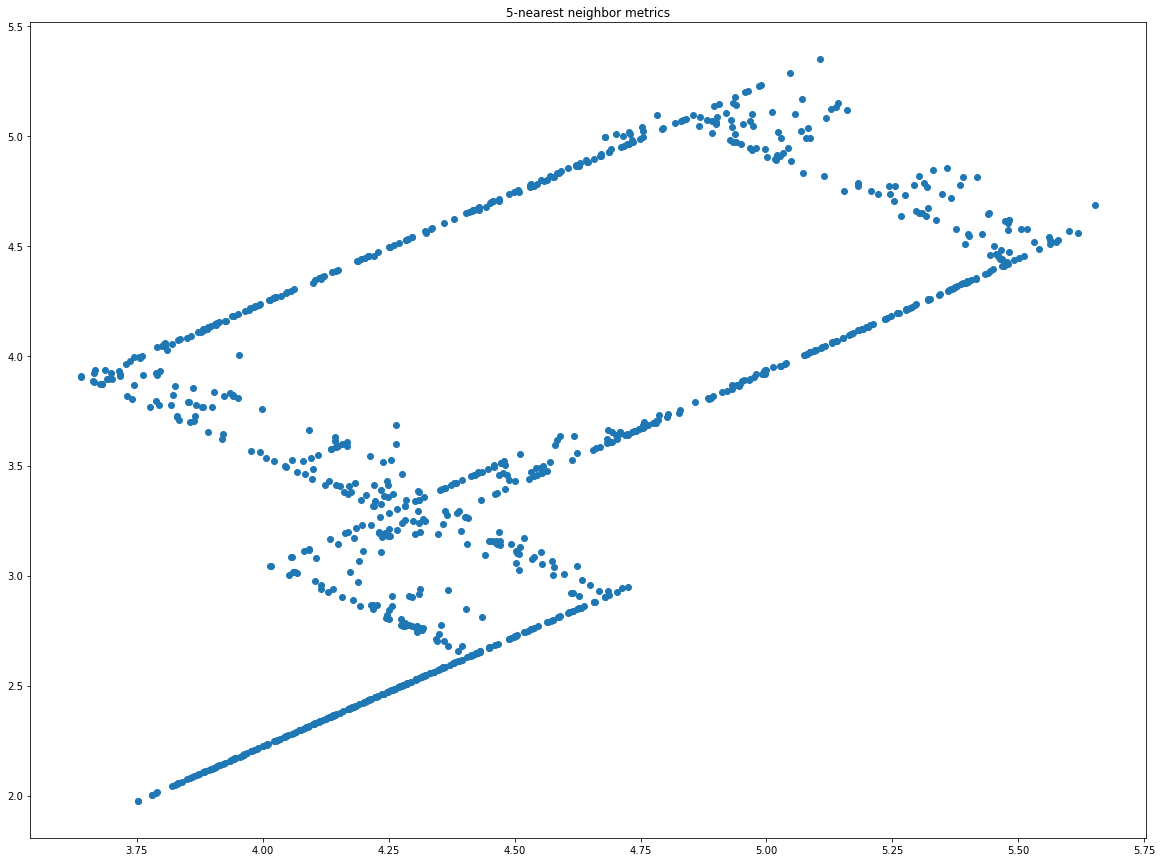

In [248]:
plt.scatter(H1[:,0], H1[:,1])
plt.title('5-nearest neighbor metrics')
plt.show()

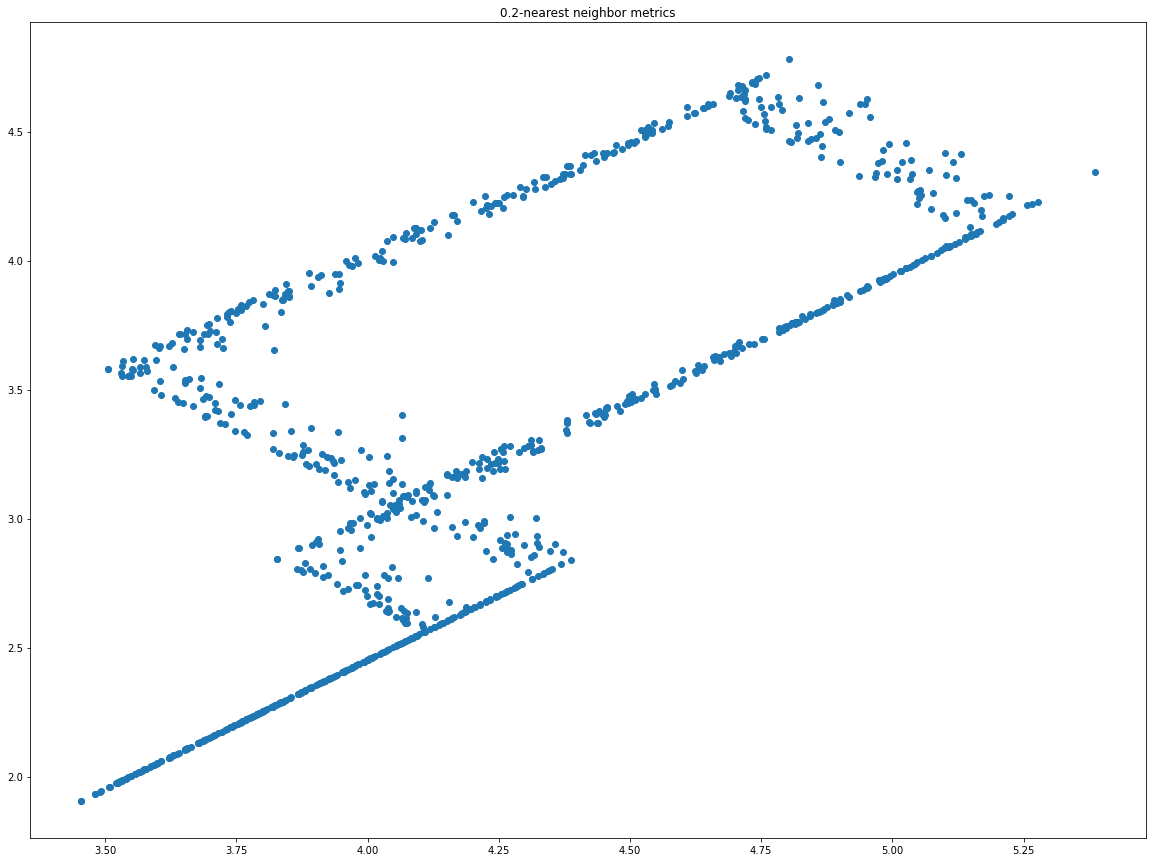

In [244]:
plt.scatter(H2[:,0], H2[:,1])
plt.title('0.2-nearest neighbor metrics')
plt.show()

## Problem 3 - ISOMAP (20 points)

You now have all the ingredients for the [ISOMAP algorithm](https://web.mit.edu/cocosci/Papers/sci_reprint.pdf), which is an early "manifold learning" algorithm.  The input is point cloud data $X$ with some distance $d$ (not necessarily Euclidean), and returns a Euclidean embedding of the space.

The algorithm is
1. Compute a neighborhood graph `G` of `X` (can be k-nearest neighbors or r-nearest neighbors), weighting edges by the distance $d$.
2. Compute the shortest path pairwise distance matrix `D` on the graph `G`
3. Compute an MDS embedding using the matrix `D`.

You can read about [scikit-learn's implementation here](https://scikit-learn.org/stable/modules/manifold.html#isomap).

### Part A - Implement ISOMAP (10 points)

Write a function `ISOMAP(X, d=2, k=5, r=None, **kwargs)` which implements the ISOMAP algorithm with an embedding dimension of `d`.  If the keyword argument `r` is provided, you should form the `r`-nearest neighbor graph.  Otherwise, form the `k`-nearest neighbor graph. `**kwargs` should be passed into either `knn_graph` or `rnn_graph`.

In [262]:
## Your code here
def ISOMAP(X, d=2, k=5, r=None, **kw):
    """
    implement MDS w.r.t. different metrics
    """
    me = kw.get('metric', 'euclidean')
    
    if r!=None:
        G = rnn_graph(X, r=r, metric=me)
    else:
        G = knn_graph(X, k=k, metric=me)
    
    D = shortest_path_metric(G)
    
    return MDS(D, k=d)

### Part B - Use ISOMAP (10 points)

Use your isomap function with the noisy circle data set in Problem 0 with the following parameters:
1. `r=0.2, metric='euclidean'`
2. `r=0.3, metric='manhattan'` ($L^1$ distance)
3. `r=0.2, metric='chebyshev'` ($L^\infty$ distance)

Create scatter plots of each embedding.

In [224]:
X = sample_noisy_sphere(1000, d=2)

In [225]:
## Your code here
# r=0.2, metric='euclidean'
T1 = ISOMAP(X, d=2, k=5, r=0.2, metric='euclidean')

# r=0.3, metric='manhattan'
T2 = ISOMAP(X, d=2, k=5, r=0.3, metric='manhattan')

# r=0.2, metric='chebyshev'
T3 = ISOMAP(X, d=2, k=5, r=0.2, metric='chebyshev')

/var/folders/0l/16z1x7f921x1hdj3spvhldym0000gn/T/ipykernel_37191/2535775591.py:23: SparseEfficiencyWarning:

Comparing a sparse matrix with 0 using == is inefficient, try using != instead.

/Users/lijinnan/.conda/envs/pycourse/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/var/folders/0l/16z1x7f921x1hdj3spvhldym0000gn/T/ipykernel_37191/2535775591.py:23: SparseEfficiencyWarning:

Comparing a sparse matrix with 0 using == is inefficient, try using != instead.

/Users/lijinnan/.conda/envs/pycourse/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/var/folders/0l/16z1x7f921x1hdj3spvhldym0000gn/T/ipykernel_37191/2535775591.py:23: SparseEfficiencyWarning:

Comparing a sparse matrix with 0 using == is inefficient, try using != instead.

/Users

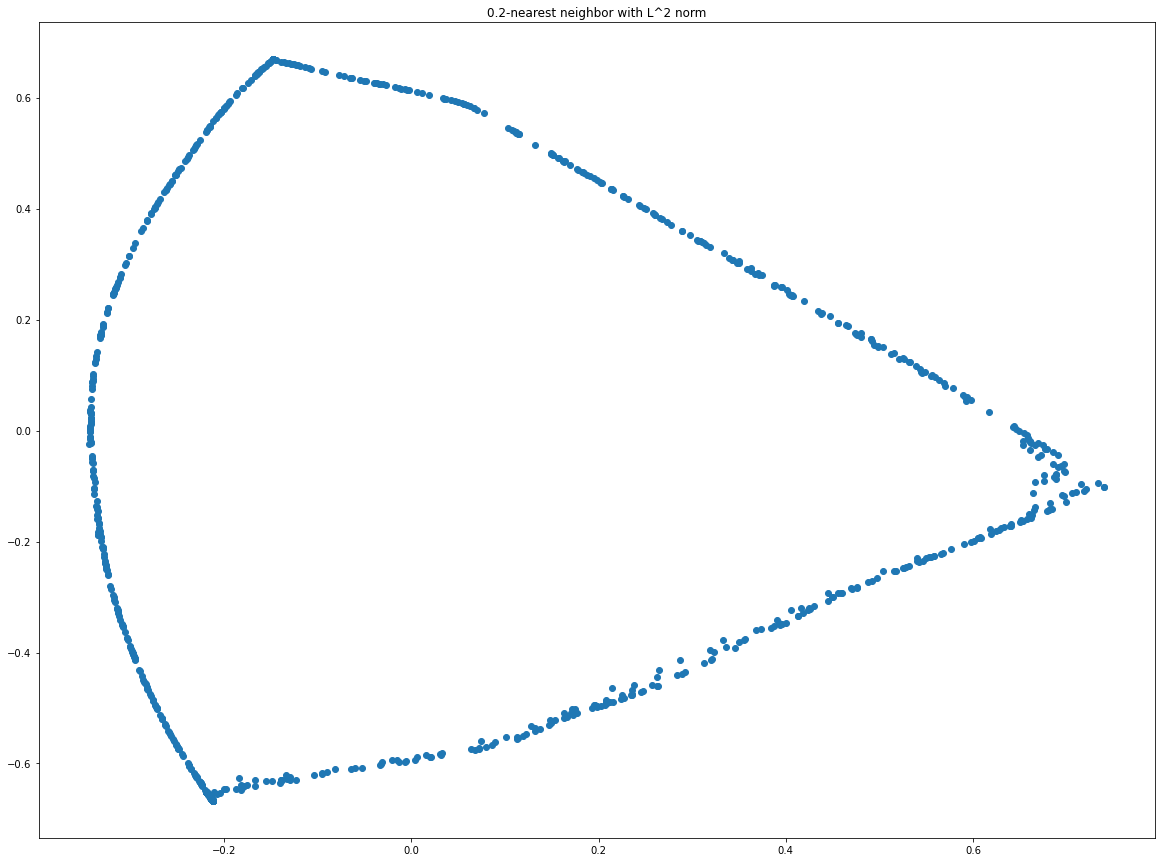

In [230]:
plt.scatter(T1[:,0], T1[:,1])
plt.title('0.2-nearest neighbor with L^2 norm')
plt.show()

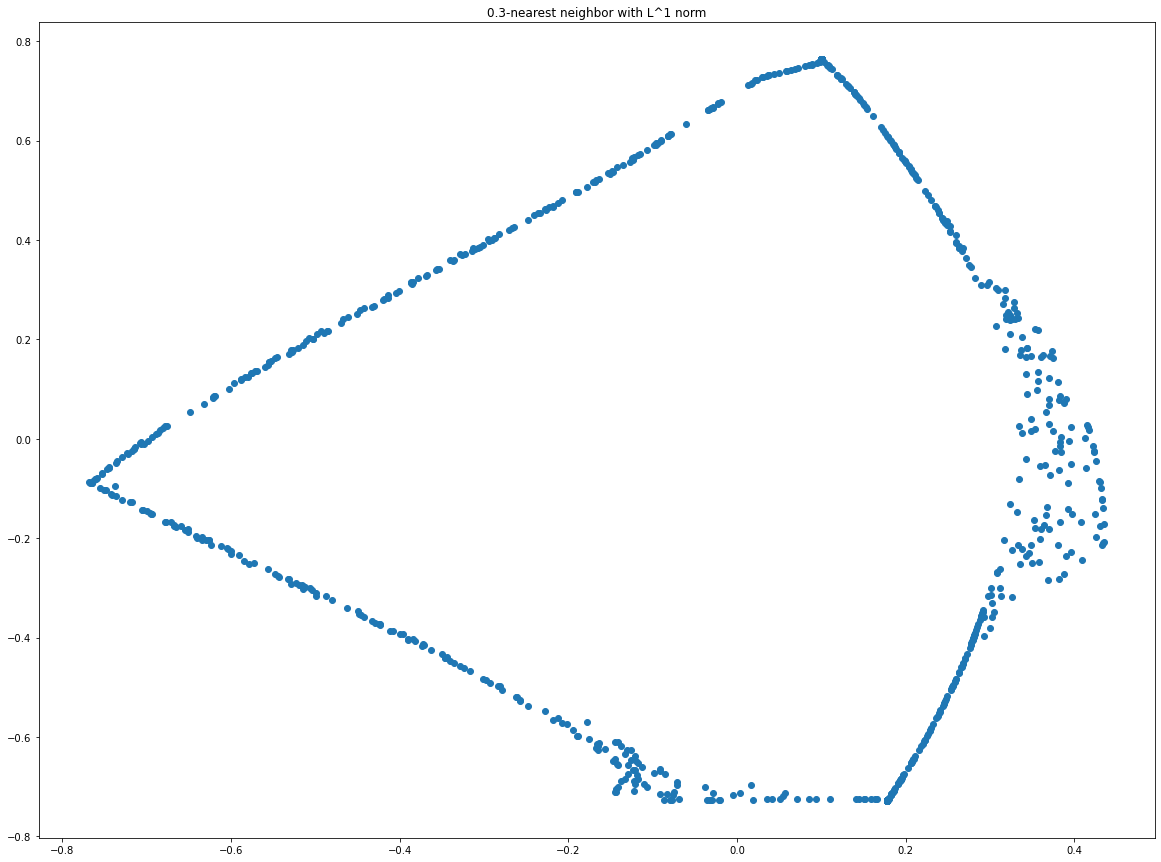

In [231]:
plt.scatter(T2[:,0], T2[:,1])
plt.title('0.3-nearest neighbor with L^1 norm')
plt.show()

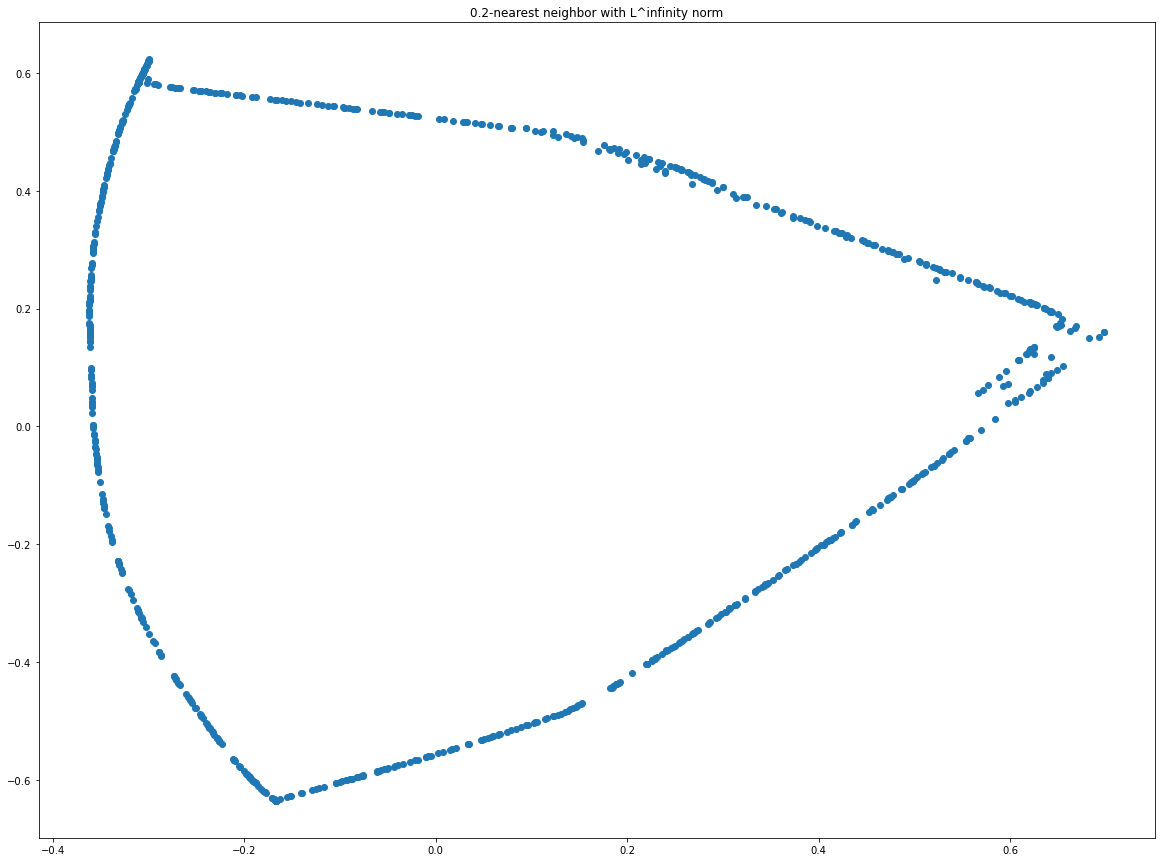

In [232]:
plt.scatter(T3[:,0], T3[:,1])
plt.title('0.2-nearest neighbor with L^infinity norm')
plt.show()

Use ISOMAP on some swiss roll data `X` generated below.  

In [266]:
import plotly
import plotly.graph_objects as go

def swiss_roll(n):
    """
    generates swiss roll on n points
    """
    X = np.random.rand(n,2)
    r = 1 + X[:,0]
    theta = 3*np.pi*X[:,0]
    return np.hstack((
        (r*np.cos(theta)).reshape(-1,1),
        (r*np.sin(theta)).reshape(-1,1),
        (2*X[:,1] - 1).reshape(-1,1)
    ))
    
X = swiss_roll(1000)

fig = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=X[:,2],
                                   mode='markers',
                                  marker=dict(
                                      size=2
                                  ))])
fig.show()

create scatter plots of the ISOMAP embedding using
1. `k=10, metric='euclidean'`
2. `k=10, metric='minkowski', p=3` ($L^3$ distance)

In [267]:
## Your code here
#  k=10, metric='euclidean'
T4 = ISOMAP(X, d=3, k=10, r=None, metric='euclidean')

# k=10, metric='minkowski', p=3
T5 = ISOMAP(X, d=3, k=10, r=None, metric='minkowski', p=3)

/var/folders/0l/16z1x7f921x1hdj3spvhldym0000gn/T/ipykernel_37191/2535775591.py:23: SparseEfficiencyWarning:

Comparing a sparse matrix with 0 using == is inefficient, try using != instead.

/Users/lijinnan/.conda/envs/pycourse/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/var/folders/0l/16z1x7f921x1hdj3spvhldym0000gn/T/ipykernel_37191/2535775591.py:23: SparseEfficiencyWarning:

Comparing a sparse matrix with 0 using == is inefficient, try using != instead.

/Users/lijinnan/.conda/envs/pycourse/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



/Users/lijinnan/.conda/envs/pycourse/lib/python3.8/site-packages/matplotlib/collections.py:1003: RuntimeWarning:

invalid value encountered in sqrt



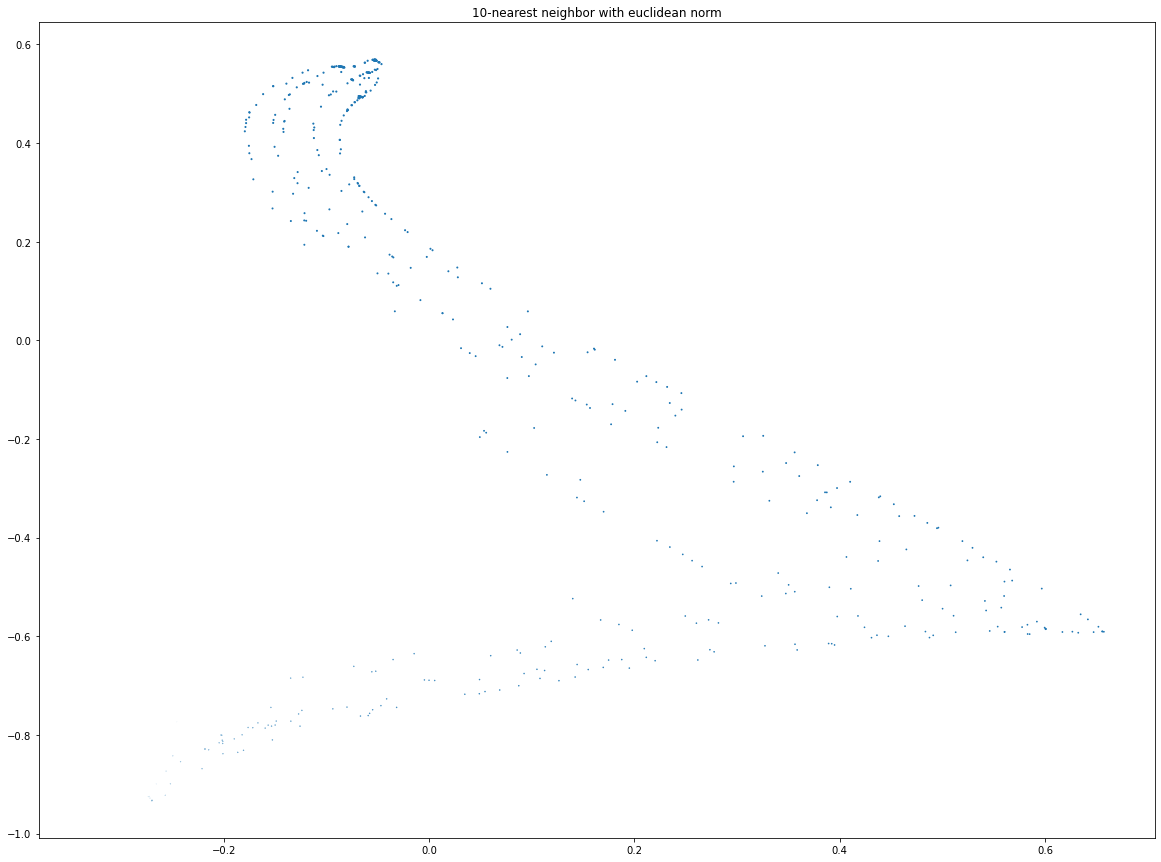

In [268]:
plt.scatter(T4[:,0], T4[:,1], T4[:,2])
plt.title('10-nearest neighbor with euclidean norm')
plt.show()

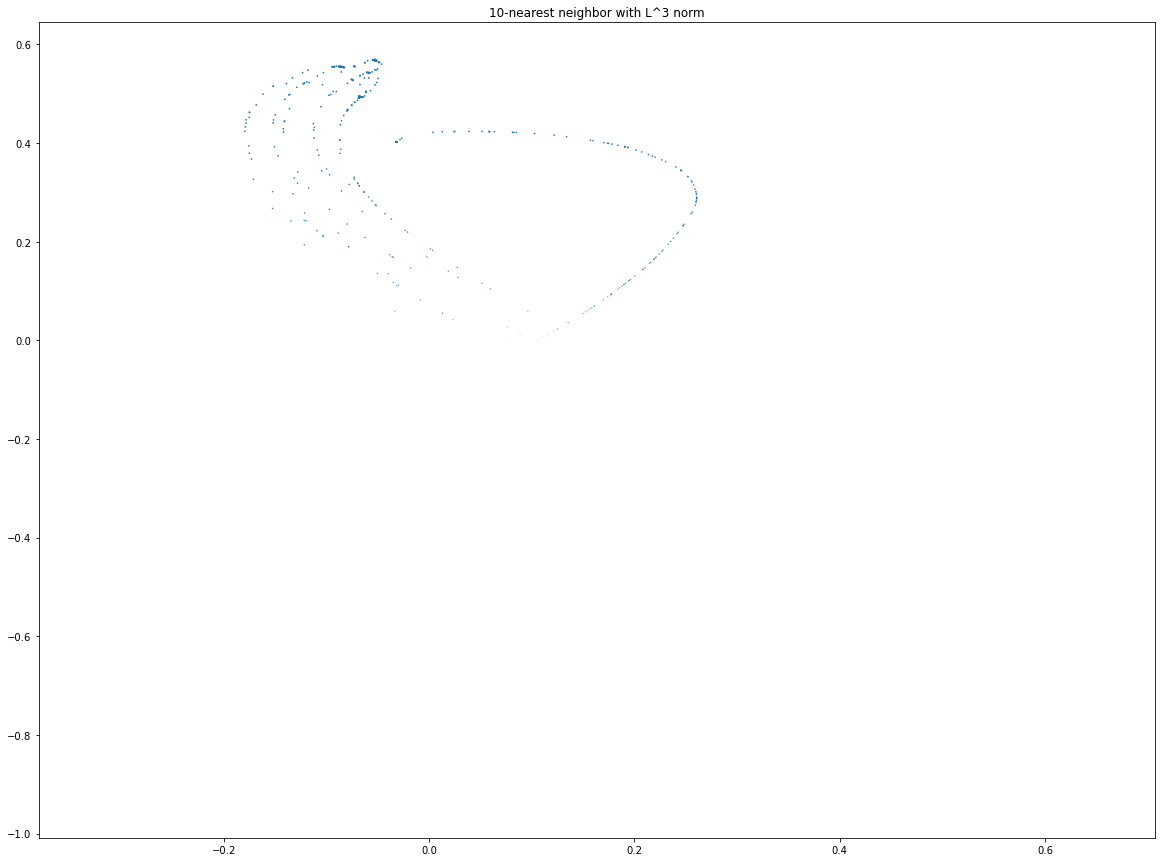

In [269]:
plt.scatter(T5[:,0], T5[:,1], T5[:,1])
plt.title('10-nearest neighbor with L^3 norm')
plt.show()